In [ ]:
# dim1 = []; #fila
# dim2 = []; #columna
# dim3 = []; #profundidad

# for i in range(len(X_train)):
#   #extraer
#   val_1 = X_train[i].shape[0]
#   val_2 = X_train[i].shape[1]
#   val_3 = X_train[i].shape[2]
#   #armar
#   dim1.append(val_1)
#   dim2.append(val_2)
#   dim3.append(val_3)

# promedio_fila = np.sum(dim1)/len(dim1)
# promedio_columna = np.sum(dim2)/len(dim2)
# promedio_profundidad = np.sum(dim3)/len(dim3)
# print(promedio_fila)
# print(promedio_columna)
# print(promedio_profundidad)

153.1028
153.1028
3.0


# Face Mask Detection

### Objetivo:
*   Detectar y clasificar si las personas en las imágenes están con o sin mascarilla puesta

### Data:


*   All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530).





In [ ]:
import numpy as np
import sympy as sp

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, Lambda, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.losses import BinaryCrossentropy            #Función de costo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from sklearn.preprocessing import MinMaxScaler     #me parece que este no se usa no?

In [ ]:
#Para que era esto?
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
#carpeta de imágenes
!unzip Facemask.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Facemask/Train/WithoutMask/1855.png  
  inflating: Facemask/Train/WithoutMask/1856.png  
  inflating: Facemask/Train/WithoutMask/1857.png  
  inflating: Facemask/Train/WithoutMask/1858.png  
  inflating: Facemask/Train/WithoutMask/1859.png  
  inflating: Facemask/Train/WithoutMask/1860.png  
  inflating: Facemask/Train/WithoutMask/1861.png  
  inflating: Facemask/Train/WithoutMask/1862.png  
  inflating: Facemask/Train/WithoutMask/1863.png  
  inflating: Facemask/Train/WithoutMask/1864.png  
  inflating: Facemask/Train/WithoutMask/1865.png  
  inflating: Facemask/Train/WithoutMask/1866.png  
  inflating: Facemask/Train/WithoutMask/1867.png  
  inflating: Facemask/Train/WithoutMask/1868.png  
  inflating: Facemask/Train/WithoutMask/1869.png  
  inflating: Facemask/Train/WithoutMask/1870.png  
  inflating: Facemask/Train/WithoutMask/1871.png  
  inflating: Facemask/Train/WithoutMask/1872.png  
  inflating: Facemask

### Distribución (with/without mask):


*   Train: 5000/5000
*   Validation: 400/400
*   Test: 483/509

In [ ]:
import sys
import cv2
import glob
import numpy as np
import pickle as cPickle
import time
import random
import scipy.cluster.vq as vq
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def prepareFiles(rootpath):
	current_GT_id=0
	filenames=[]
	GT_ids=[]
	GT_labels=[]
	classpath = sorted(glob.glob(rootpath+'*'))
	for i in classpath:
		filespath = sorted(glob.glob(i+'/*.png'))
		for j in filespath:
			filenames.append(j)
			GT_ids.append(current_GT_id)
			GT_labels.append(i.split('/')[-1])
		current_GT_id+=1
	return(filenames,GT_ids,GT_labels)

In [ ]:
# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_train='./Facemask/Train/'

# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_valid='./Facemask/Validation/'

# Directorio raiz donde se encuentran todas las imágenes de test
dataset_folder_test='./Facemask/Test/'

In [ ]:
# Separación de train, valid, test
# Cálculo de puntos de interés para todas las imágenes del conjunto de aprendizaje
filenames_train,GT_ids_train,GT_labels_train = prepareFiles(dataset_folder_train)
filenames_valid,GT_ids_valid,GT_labels_valid = prepareFiles(dataset_folder_valid)
filenames_test,GT_ids_test,GT_labels_test = prepareFiles(dataset_folder_test)


#filenames_train: contiene todas las imágenes de train
#GT_ids_train: contiene las clases a la que pertenecen cada imagen
#GT_labels_train: son las etiquetas de cada clase de imágen

In [ ]:
filenames_train[5999]

'./Facemask/Train/WithoutMask/2072.png'

In [ ]:
GT_ids_train[0]

0

In [ ]:
def getKeypointsDescriptors(filenames):
  A=[]
  print('Obtaining the images matrix from the filenames')
  init=time.time()
  for filename in filenames:
    ima=cv2.imread(filename)
    #ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
    ima = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    dim = (256, 256)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA)
    A.append(ima)
  end=time.time()
  print('Done in '+str(end-init)+' secs.')
  return(A)

In [ ]:
#Train:
X_train = getKeypointsDescriptors(filenames_train)
y_train = GT_ids_train 

#Validation:
X_valid = getKeypointsDescriptors(filenames_valid)
y_valid = GT_ids_valid 

#Test:
X_test = getKeypointsDescriptors(filenames_test)
y_test = GT_ids_test

Obtaining the images matrix from the filenames
Done in 11.451592683792114 secs.
Obtaining the images matrix from the filenames
Done in 0.8766484260559082 secs.
Obtaining the images matrix from the filenames
Done in 1.086538553237915 secs.


In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
import numpy as np
np.unique(y_train)

#Clasificador binario -> No es necesario one hot encoder

array([0, 1])

In [ ]:
X_train.shape

(10000, 256, 256)

In [ ]:
X_train.shape[1:]

(256, 256)

In [ ]:
# Tamaños (With and Wuthout mask)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_valid.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# Número de datos de entrenamiento y de prueba
ntrain = X_train.shape[0]
nvalid = X_valid.shape[0]
ntest = X_test.shape[0]

# Tamaño de la imagen
npx = X_train.shape[1] 

Tamaño del conjunto de entrenamiento: (10000, 256, 256)
Tamaño del conjunto de validación: (800, 256, 256)
Tamaño del conjunto de prueba: (992, 256, 256)


Mostrando 3 imágenes de ejemplos

In [ ]:
#Dado que los labels de la data están basados en números, genero este vector para poder facilitar visualmente
class_names = ['Wearing mask', 'No wearing mask']

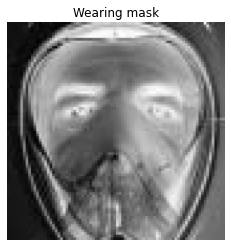

In [ ]:
#mostrar imagen
idx = 0
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()


    # ima = np.resize(ima, (153, 153))
    # ima = np.reshape(ima, (164, 123))

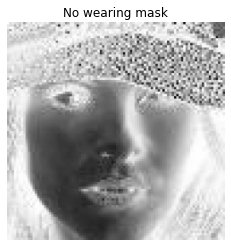

In [ ]:
#mostrar imagen
idx = 5100
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

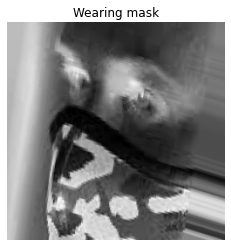

In [ ]:
#mostrar imagen
idx = 4011
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

Preprocesamiento:

In [ ]:
# Aumentar 1 dimension para que esté en formato que acepta Keras (escala a grises)
X_train = X_train.reshape(ntrain, npx, npx, 1) 
X_valid = X_valid.reshape(nvalid, npx, npx, 1)
X_test = X_test.reshape(ntest, npx, npx, 1)   

print("Tamaño modificado del conjunto de entrenamiento:", X_train.shape)
print("Tamaño modificado del conjunto de validacion:", X_valid.shape)
print("Tamaño modificado del conjunto de prueba:", X_test.shape)

Tamaño modificado del conjunto de entrenamiento: (10000, 256, 256, 1)
Tamaño modificado del conjunto de validacion: (800, 256, 256, 1)
Tamaño modificado del conjunto de prueba: (992, 256, 256, 1)


In [ ]:
#Normalizando
X_train = X_train/255.        #el . es para que sea float
X_valid = X_valid/255.
X_test = X_test/255.

In [ ]:
X_train.shape

(10000, 256, 256, 1)

In [ ]:
X_train.shape[1]

256

# Creando Red Neuronal

In [ ]:
# DNN-1
model = Sequential()
model.add(Flatten(input_shape=(256,256,1)))     # entran 256x256x1 datos a cada neurona
model.add(Dense(100))
model.add(BatchNormalization())             #el Batch debe estar entre la convalidación(Dense) y el activation
model.add(Activation('swish'))
model.add(Dropout(0.5))                   #borra aleatoriamente la mitad de las neuronas de esta capa con cada iteración
                                          #dropout sirve para evitar la memorización de datos(overfitting) 
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('swish'))          #swish mejor que relu
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# ¿Por qué un batch normalization? es útil para estandarizar las entradas de la red neuronal
# y así acelerar el proceso de entrenamiento proporcionando una mejor regularizacion y mejorar el accuracy

model.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(learning_rate=0.001),
             metrics=['accuracy', 'AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 100)               6553700   
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                        

In [ ]:
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'       #para almacenar cada mejor modelo encontrado con con cada iteracion

cp = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss',
                     verbose=1, 
                     save_best_only=True,
                     mode='min')
#el checkpoint(cp) guardará los parámetros del modelo que generen el mínimo de 'val_loss' y se quedará con esos hasta que aparezca un menor a loss

es = EarlyStopping(monitor='val_loss',
                   patience=20,
                   mode='min',
                   verbose=0,
                   restore_best_weights=True)
# si "es" detecta 20 veces seguidas que el 'val_loss' está subiendo(malo) entonces parará las iteraciones

pl = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patince=5,
                       verbose=0,
                       mode='min')
#reduce(multiplica) al 'learning_rate' en un factor de 0.2 cada 5 veces seguidas que el val_loss se reduzca

In [ ]:
history = model.fit(x=X_train,
          y=y_train,
          batch_size=100,
          epochs=5,
          validation_data=(X_valid, y_valid),
          shuffle=True,
          verbose=True,
          callbacks=[cp, es, pl]
         )

#batch_size: define la cantidad de subgrupos a entrenar del grupo total
#si tengo 1000 datos, debo hacer un batch_size multiplo de aquel valor -> 10 o 100

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.7132 - auc: 0.7740
Epoch 00001: val_loss improved from inf to 0.61377, saving model to ./my_best_model.epoch01-loss0.61.hdf5
100/100 [==============================] - 12s 106ms/step - loss: 0.5840 - accuracy: 0.7132 - auc: 0.7740 - val_loss: 0.6138 - val_accuracy: 0.6800 - val_auc: 0.8942 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8472 - auc: 0.9226
Epoch 00002: val_loss improved from 0.61377 to 0.57219, saving model to ./my_best_model.epoch02-loss0.57.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.3917 - accuracy: 0.8472 - auc: 0.9226 - val_loss: 0.5722 - val_accuracy: 0.6975 - val_auc: 0.9468 - lr: 0.0010
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8833 - auc: 0.9464
Epoch 00003: val_loss improved from 0.57219 to 0.37962, saving model to ./my_best_model.epoch03-loss

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

In [ ]:
import matplotlib.pyplot as plt

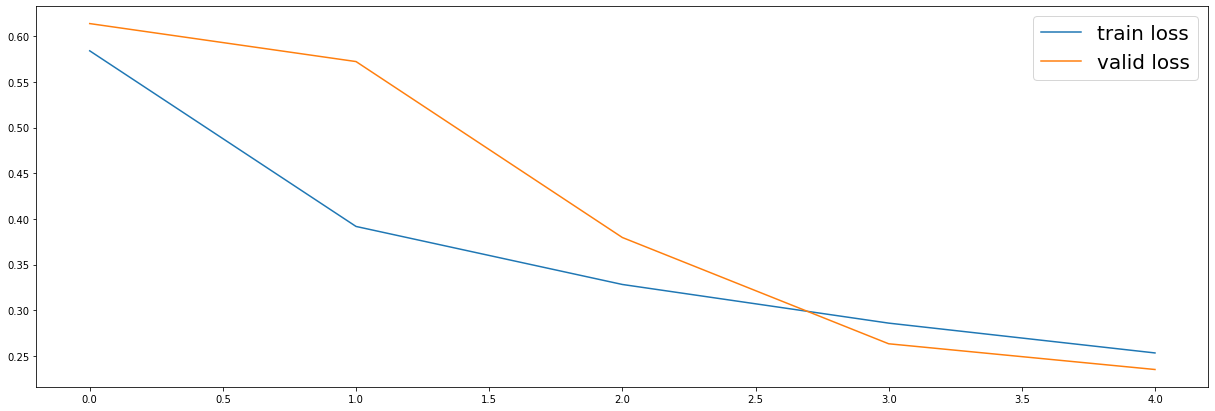

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend(fontsize=20)

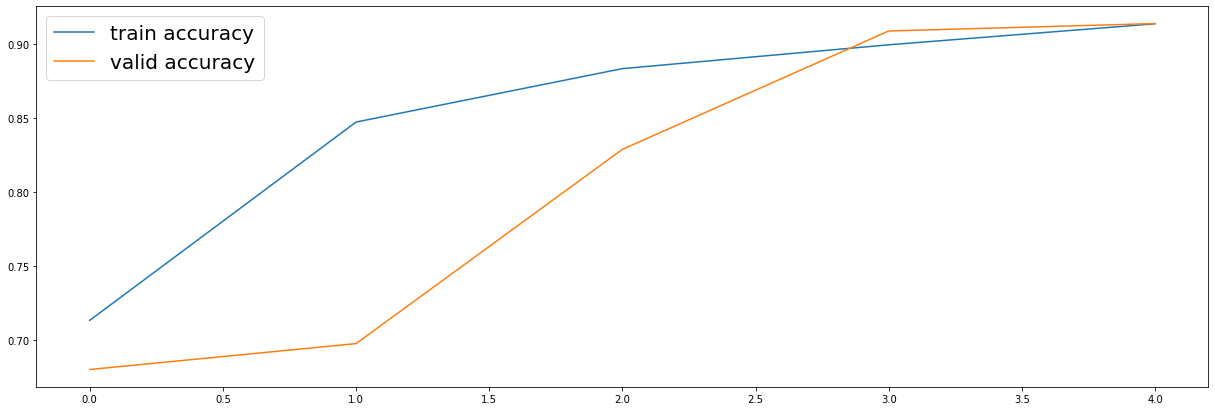

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend(fontsize=20)